In [10]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import scipy 
from skimage.util import img_as_float
from scipy import interpolate
from scipy.interpolate import RectBivariateSpline
from skimage.filters import sobel
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour

In [11]:

def init_snake(filename):
    file = open(filename)
    line = file.readline()
    x_old = float(line.split(' ')[0])
    y_old = float(line.split(' ')[1])
    x = [y_old]
    y = [x_old]
    x_new = 0
    y_new = 0
    while ((x_old != x_new) or (y_old != y_new)):
        line = file.readline()
        x_new = float(line.split(' ')[0])
        y_new = float(line.split(' ')[1])
        x.append(y_new)
        y.append(x_new)
    snake = np.array([x, y])
    return snake.T


def reparametrization(snake):
    s = np.zeros(snake.shape[0])
    curve_len = 0
    for i in range(0, snake.shape[0]):
        curve_len += np.linalg.norm(snake[i] - snake[i - 1])
        s[i] = curve_len
        #print(curve_len)
    f_x_1 = interpolate.interp1d(s, snake[:, 0])
    f_y_1 = interpolate.interp1d(s, snake[:, 1])
    for i in range(0, snake.shape[0] - 1):
        snake[i][0] = f_x_1(i * curve_len / snake.shape[0])
        snake[i][1] = f_y_1(i * curve_len / snake.shape[0])
    return snake.copy()

def my_active_contour(image, snake, alpha=0.01, beta=0.1,
                   w_line=0, w_edge=1, gamma=0.01, kappa = 0.01,
                   max_iterations=500, convergence=0.1):
    img = image.copy()
    edge = [sobel(img)]
    img = w_line*img + w_edge*edge[0]
    
    intp = RectBivariateSpline(np.arange(img.shape[1]), np.arange(img.shape[0]), img.T, kx=2, ky=2, s=0)
    
    snake_xy = snake[:, ::-1]
    x, y = snake_xy[:, 0].astype(float), snake_xy[:, 1].astype(float)
    n = len(x)
    
    a = np.roll(np.eye(n), -1, axis=0) + np.roll(np.eye(n), -1, axis=1) - 2*np.eye(n)  
    b = np.roll(np.eye(n), -2, axis=0) + np.roll(np.eye(n), -2, axis=1) - 4*np.roll(np.eye(n), -1, axis=0) -4*np.roll(np.eye(n), -1, axis=1) + 6*np.eye(n)  
    A = -alpha*a + beta*b
    inv = np.linalg.inv(A + gamma*np.eye(n))
    
    normal_x = np.zeros(x.shape)
    normal_y = np.zeros(y.shape)
    for i in range(max_iterations // 4):
        for j in range (0, 4):
            
            for k in range(0, x.shape[0] - 1):
                normal_x[k] = (y[k + 1] - y[k])
                normal_y[k] = (x[k] - x[k + 1])
                
            fx = intp(x, y, dx=1, grid=False)
            fy = intp(x, y, dy=1, grid=False)
            
            fx /= np.linalg.norm(fx)
            fy /= np.linalg.norm(fy)
            
            xn = inv @ (gamma*x + fx + kappa * normal_x)
            yn = inv @ (gamma*y + fy + kappa * normal_y)
            dx = xn - x
            dy = yn - y
            x += dx
            y += dy
            x[-1] = x[0]
            y[-1] = y[0]
            
            dist = np.max(np.abs(dx) + np.abs(dy))
            if dist < convergence:
                break
        
        if dist < convergence:
            break
        snake = np.stack([y, x], axis=1)  
        snake = reparametrization(snake)
        x = snake[:, 1]
        y = snake[:, 0]
    return np.stack([y, x], axis=1)  

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio

def display_image_in_actual_size(img, dpi = 80):
    height = img.shape[0]
    width = img.shape[1]

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(img, cmap='gray')

#     plt.show()
    
    return fig, ax

def save_mask(fname, snake, img):
    plt.ioff()
    fig, ax = display_image_in_actual_size(img)
    ax.fill(snake[:, 0], snake[:, 1], '-b', lw=3)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    fig.savefig(fname, pad_inches=0, bbox_inches='tight', dpi='figure')
    plt.close(fig)
    
    mask = skio.imread(fname)
    blue = (((mask[:,:,2] == 255) & (mask[:,:,1] < 255) & (mask[:,:,0] < 255)) * 255).astype(np.uint8)
    skio.imsave(fname, blue)
    plt.ion()
    
def display_snake(img, init_snake, result_snake):
    fig, ax = display_image_in_actual_size(img)
    ax.plot(init_snake[:, 0], init_snake[:, 1], '-r', lw=2)
    ax.plot(result_snake[:, 0], result_snake[:, 1], '-b', lw=2)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])
    plt.show()
    
def IoU(img1, img2):
    overlap = 0
    union = 0
    for i in range(0, img1.shape[0]):
        for j in range(0, img1.shape[1]):
            if (img1[i][j] or img2[i][j]):
                union += 1
                if (img1[i][j] and img2[i][j]):
                    overlap += 1
    return overlap / union

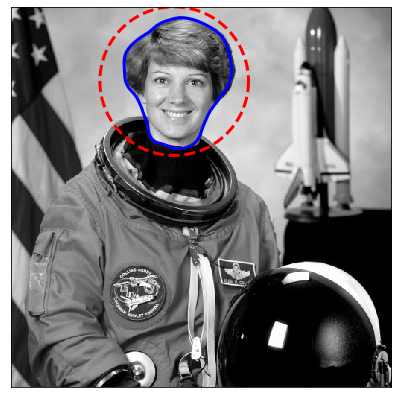

0.9609936805404228


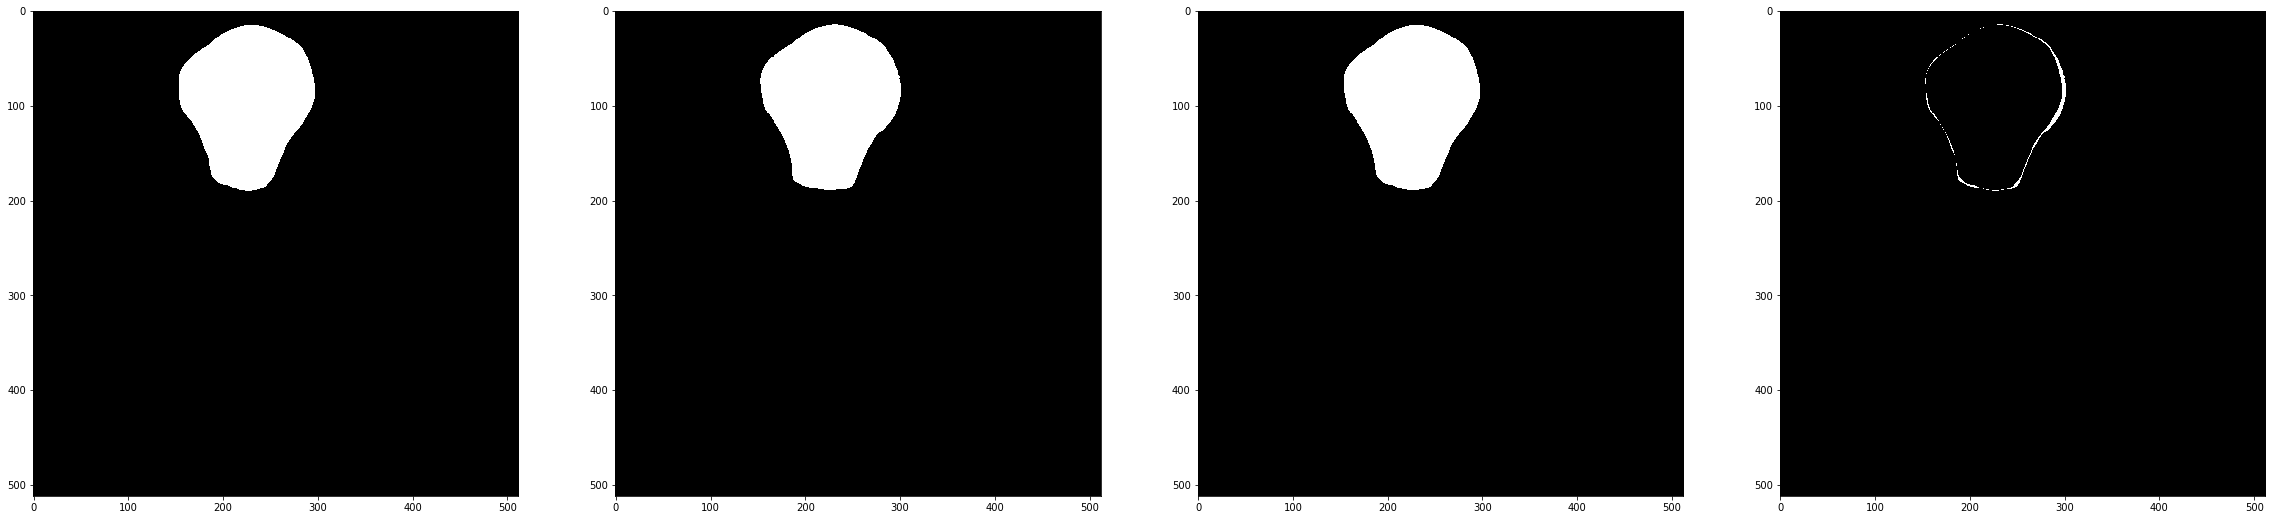

In [12]:
img = skimage.io.imread("resources/astranaut.png")
init = init_snake("resources/astranaut_init_snake.txt")

snake = my_active_contour(gaussian(img, 3),
                       init, alpha=1., beta=0.7, w_line = 0.1, w_edge = 1.4, gamma=0.02, kappa = 0.0)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

result_snake = np.array([snake[:,1], snake[:,0]]).T
save_mask("result.png", result_snake, img)
my_mask = skimage.io.imread("result.png")
ground_truth = skimage.io.imread("resources/astranaut_mask.png")

print(IoU(my_mask, ground_truth))

union_minus_overleap = np.zeros(my_mask.shape)
for i in range(0, my_mask.shape[0]):
    for j in range(0, my_mask.shape[1]):
        union_minus_overleap[i][j] = (my_mask[i][j] != ground_truth[i][j]) * 255
imgs = [my_mask, ground_truth, my_mask * ground_truth, union_minus_overleap]
_, axs = plt.subplots(ncols = len(imgs), figsize = (40, 40))

for index in range(0, len(imgs)):
    axs[index].imshow(imgs[index], cmap = "gray")

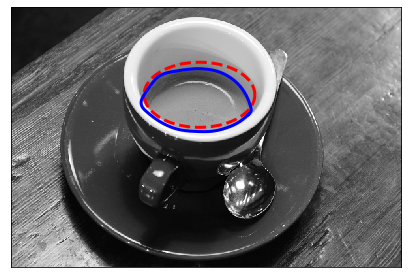

0.9465550547327752


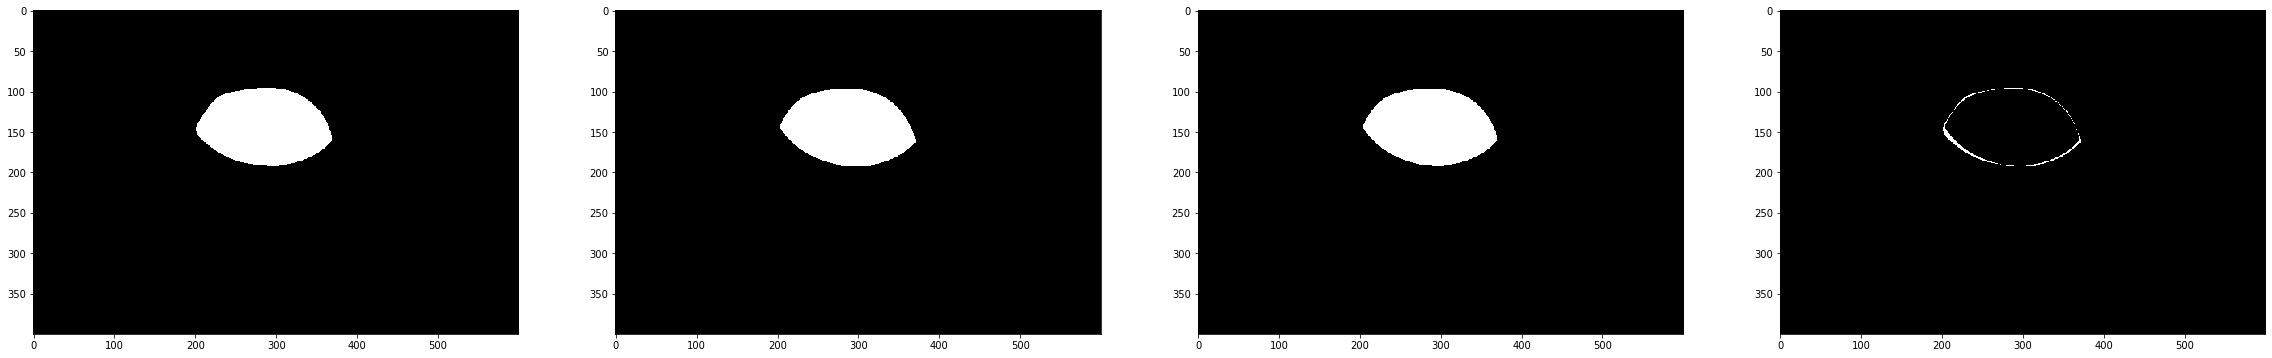

In [13]:
img = skimage.io.imread("resources/coffee.png")
init = init_snake("resources/coffee_init_snake.txt")

snake = my_active_contour(gaussian(img, 3),
                       init, alpha=1., beta=0.7, kappa = 0.0, w_line = 0.1, w_edge = 1.4, gamma=0.02, max_iterations = 505, convergence = 1.)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()


result_snake = np.array([snake[:,1], snake[:,0]]).T
save_mask("result_coffee.png", result_snake, img)
my_mask = skimage.io.imread("result_coffee.png")
ground_truth = skimage.io.imread("resources/coffee_mask.png")

print(IoU(my_mask, ground_truth))

union_minus_overleap = np.zeros(my_mask.shape)
for i in range(0, my_mask.shape[0]):
    for j in range(0, my_mask.shape[1]):
        union_minus_overleap[i][j] = (my_mask[i][j] != ground_truth[i][j]) * 255
imgs = [my_mask, ground_truth, my_mask * ground_truth, union_minus_overleap]
_, axs = plt.subplots(ncols = len(imgs), figsize = (40, 40))

for index in range(0, len(imgs)):
    axs[index].imshow(imgs[index], cmap = "gray")

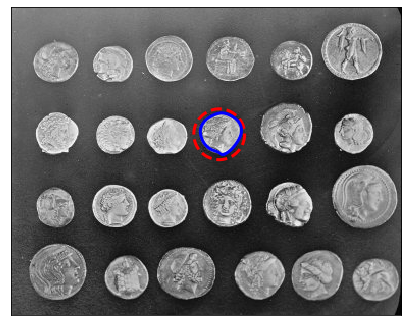

0.8720456397718012


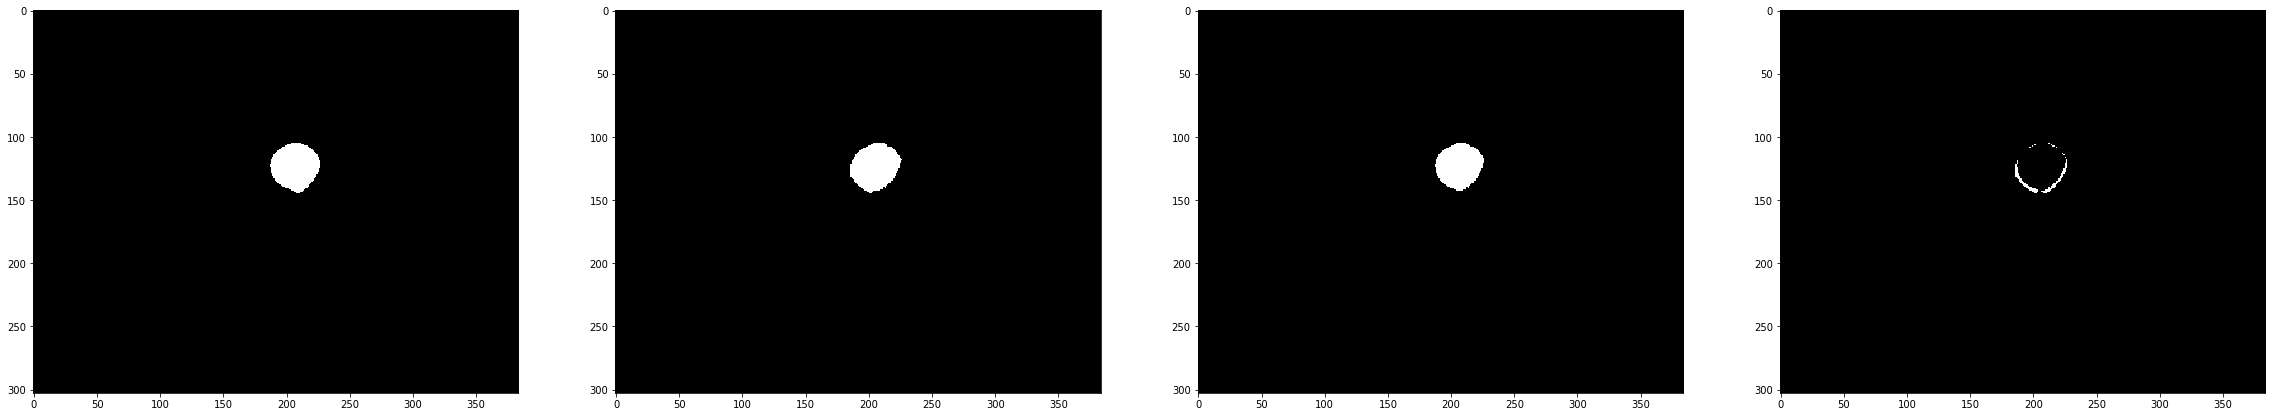

In [14]:
img = skimage.io.imread("resources/coins.png")
init = init_snake("resources/coins_init_snake.txt")

snake = my_active_contour(gaussian(img, 3),
                       init, alpha=1.5, beta=1., kappa = 0.0, w_line = -0., w_edge = 1.4, gamma=0.02, max_iterations = 505, convergence = 1.)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

result_snake = np.array([snake[:,1], snake[:,0]]).T
save_mask("result_coins.png", result_snake, img)
my_mask = skimage.io.imread("result_coins.png")
ground_truth = skimage.io.imread("resources/coins_mask.png")

print(IoU(my_mask, ground_truth))

union_minus_overleap = np.zeros(my_mask.shape)
for i in range(0, my_mask.shape[0]):
    for j in range(0, my_mask.shape[1]):
        union_minus_overleap[i][j] = (my_mask[i][j] != ground_truth[i][j]) * 255
imgs = [my_mask, ground_truth, my_mask * ground_truth, union_minus_overleap]
_, axs = plt.subplots(ncols = len(imgs), figsize = (40, 40))

for index in range(0, len(imgs)):
    axs[index].imshow(imgs[index], cmap = "gray")

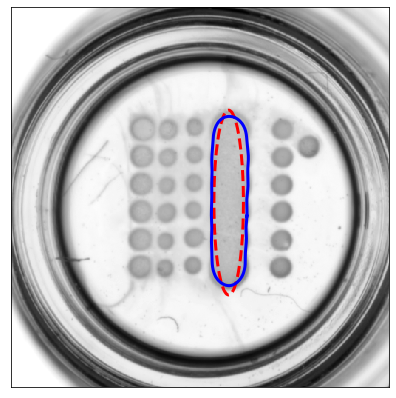

0.8113765082491997


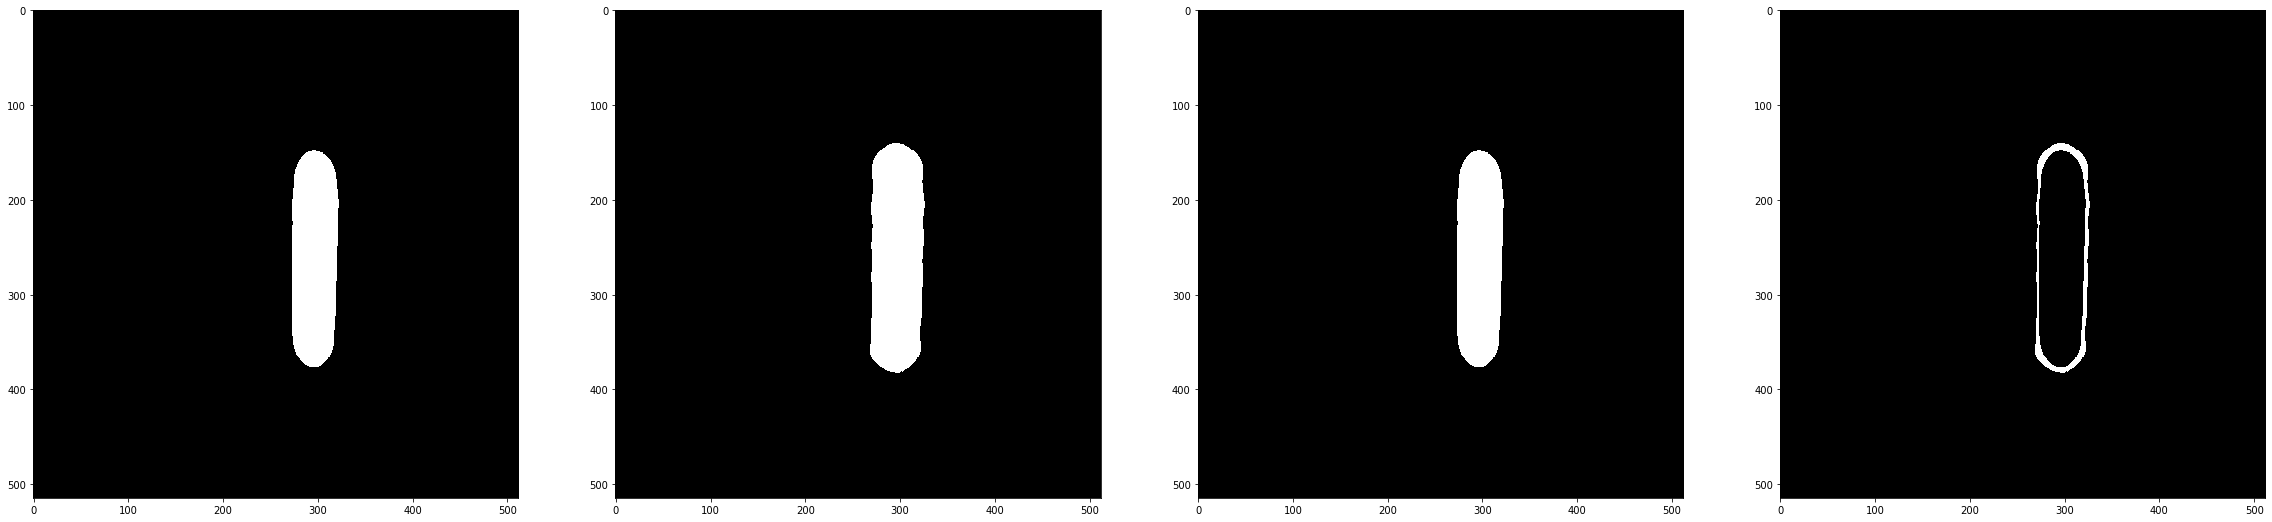

In [15]:
img = skimage.io.imread("resources/microarray.png")
init = init_snake("resources/microarray_init_snake.txt")

snake = my_active_contour(gaussian(img, 3),
                       init, alpha=1.8, beta=0.5, kappa = 0.045, w_line = -3.0, w_edge = 1.5, gamma=0.02, max_iterations = 500, convergence = 1.)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

result_snake = np.array([snake[:,1], snake[:,0]]).T
save_mask("result_microarray.png", result_snake, img)
my_mask = skimage.io.imread("result_microarray.png")
ground_truth = skimage.io.imread("resources/microarray_mask.png")

print(IoU(my_mask, ground_truth))

union_minus_overleap = np.zeros(my_mask.shape)
for i in range(0, my_mask.shape[0]):
    for j in range(0, my_mask.shape[1]):
        union_minus_overleap[i][j] = (my_mask[i][j] != ground_truth[i][j]) * 255
imgs = [my_mask, ground_truth, my_mask * ground_truth, union_minus_overleap]
_, axs = plt.subplots(ncols = len(imgs), figsize = (40, 40))

for index in range(0, len(imgs)):
    axs[index].imshow(imgs[index], cmap = "gray")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """Entry point for launching an IPython kernel.


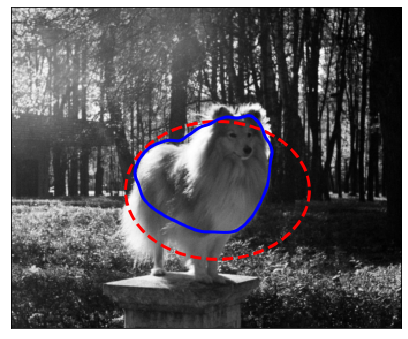

In [16]:
img = scipy.misc.imresize(skimage.io.imread('kirik.jpg')[100:1500, 500:2200], (280, 340, 3))
img = rgb2gray(img)

s = np.linspace(0, 2*np.pi, 400)
r = 160 + 60*np.sin(s)
c = 180 + 80*np.cos(s)
init = np.array([r, c]).T

snake = my_active_contour(gaussian(img, 3),
                       init, alpha=1.3, beta=0.5, kappa = 0.005, w_line = 0., w_edge = 1.9, gamma=0.02, max_iterations = 485, convergence = 1.)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()